# Etapa 7: Filtragem Digital


**Objetivo:** Reduzir ou preservar componentes espectrais específicas do sinal.


**Tarefas:**
* Aplicar filtros como passa-baixa, passa-alta, passa-faixa ou rejeita-faixa.
* Avaliar como isso afeta a fidelidade do sinal.
* Escolher e aplicar um filtro.
* Mostrar o efeito no gráfico do sinal.
* Explicar o impacto no conteúdo do sinal.

**Entrega esperada:**
* Gráficos antes/depois da filtragem.
* Tipo de filtro usado e justificativa.
* Análise dos efeitos espectrais esperados.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft
from scipy.signal import butter, filtfilt, freqz


## Recuperação do Sinal Processado (Etapa 6)


In [2]:
# Reproduzir o processamento da Etapa 6 para obter o sinal de entrada
# Parâmetros do sinal (consistente com Etapas Anteriores)
f_fundamental = 1  # Hz
T = 1 / f_fundamental # Período
amplitude = 1
n_ciclos_plot = 3 # Número de ciclos para plotagem

# Parâmetros de digitalização
fs_escolhida = 20 # Hz - Frequência de amostragem
N_bits = 4 # Número de bits para quantização
L = 2**N_bits  # Número de níveis de quantização

# Gerar sinal digital original
t_amostrado = np.arange(0, n_ciclos_plot * T, 1/fs_escolhida)
sinal_amostrado = amplitude * signal.square(2 * np.pi * f_fundamental * t_amostrado)

# Quantização
sinal_normalizado = (sinal_amostrado + amplitude) / (2 * amplitude)
niveis_quantizados_indices = np.round(sinal_normalizado * (L - 1))
sinal_quantizado_normalizado = niveis_quantizados_indices / (L - 1)
sinal_digital_original = (sinal_quantizado_normalizado * (2 * amplitude)) - amplitude

# Aplicar processamento da Etapa 6 (Ruído + Clipping)
def adicionar_ruido_awgn(sinal, snr_db):
    potencia_sinal = np.mean(sinal**2)
    snr_linear = 10**(snr_db/10)
    potencia_ruido = potencia_sinal / snr_linear
    sigma_ruido = np.sqrt(potencia_ruido)
    ruido = np.random.normal(0, sigma_ruido, len(sinal))
    return sinal + ruido, ruido

# Reproduzir o processamento exato da Etapa 6
np.random.seed(42)  # Para reprodutibilidade
sinal_com_ruido, _ = adicionar_ruido_awgn(sinal_digital_original, 8)  # SNR = 8 dB
sinal_processado_entrada = np.clip(sinal_com_ruido, -0.7, 0.7)  # Clipping em ±0.7

# Sinal contínuo de referência
t_continuo = np.linspace(0, n_ciclos_plot * T, 1000, endpoint=False)
onda_quadrada_continua = amplitude * signal.square(2 * np.pi * f_fundamental * t_continuo)

print(f"Sinal de entrada para filtragem:")
print(f"- Número de amostras: {len(sinal_processado_entrada)}")
print(f"- Taxa de amostragem: {fs_escolhida} Hz")
print(f"- Faixa de amplitude: [{np.min(sinal_processado_entrada):.3f}, {np.max(sinal_processado_entrada):.3f}]")


Sinal de entrada para filtragem:
- Número de amostras: 60
- Taxa de amostragem: 20 Hz
- Faixa de amplitude: [-0.700, 0.700]


## Visualização do Sinal de Entrada (Pós-processamento)


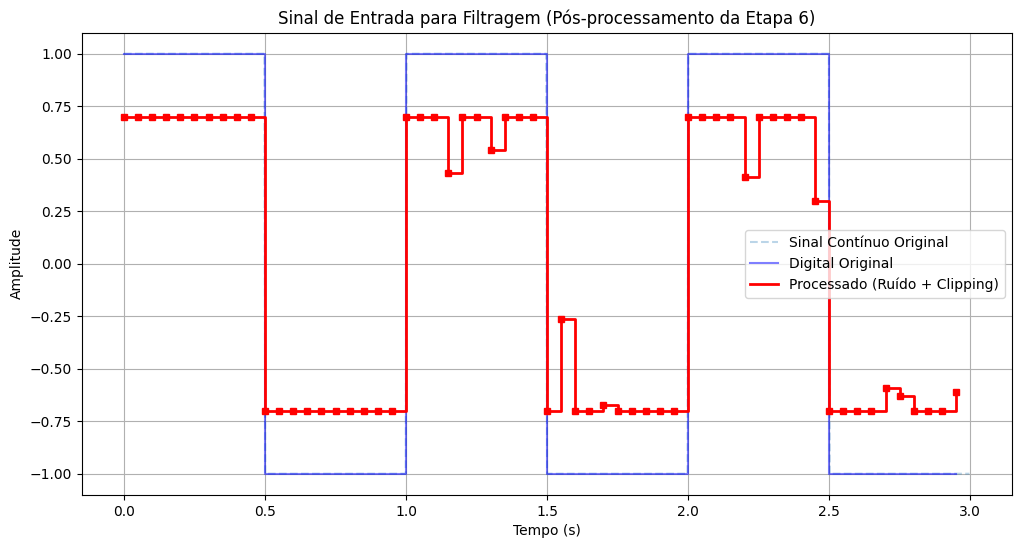

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(t_continuo, onda_quadrada_continua, label='Sinal Contínuo Original', alpha=0.3, linestyle='--')
plt.step(t_amostrado, sinal_digital_original, where='post', color='blue', alpha=0.5, label='Digital Original')
plt.step(t_amostrado, sinal_processado_entrada, where='post', color='red', label='Processado (Ruído + Clipping)', linewidth=2)
plt.plot(t_amostrado, sinal_processado_entrada, marker='s', color='red', linestyle='None', markersize=4)

plt.title('Sinal de Entrada para Filtragem (Pós-processamento da Etapa 6)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


## Análise Espectral do Sinal de Entrada


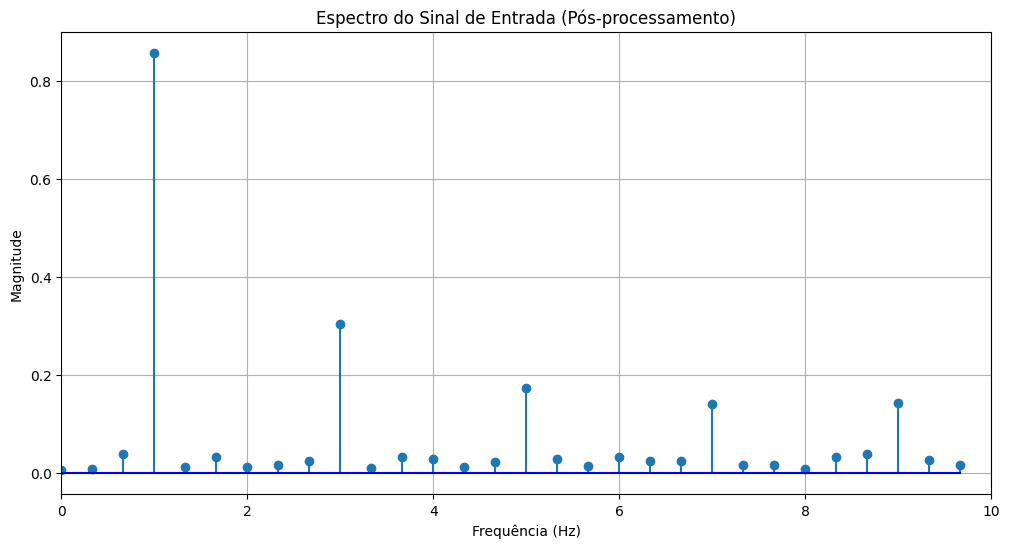

Componentes espectrais principais:
  1.00 Hz: 0.8568
  3.00 Hz: 0.3043
  5.00 Hz: 0.1748
  7.00 Hz: 0.1420
  9.00 Hz: 0.1424


In [4]:
# Análise espectral do sinal de entrada
def calcular_espectro(sinal, fs, titulo="Espectro"):
    """Calcula e plota o espectro de um sinal"""
    N = len(sinal)
    Y = fft.fft(sinal)
    freqs = fft.fftfreq(N, d=1/fs)
    
    # Pegar apenas a parte positiva
    N_metade = N // 2
    Y_metade = Y[:N_metade]
    freqs_metade = freqs[:N_metade]
    
    # Calcular módulo
    modulo = np.abs(Y_metade) * (2 / N)
    modulo[0] = np.abs(Y_metade[0]) / N  # Correção para DC
    
    return freqs_metade, modulo

# Calcular espectro do sinal de entrada
freqs_entrada, modulo_entrada = calcular_espectro(sinal_processado_entrada, fs_escolhida)

plt.figure(figsize=(12, 6))
plt.stem(freqs_entrada, modulo_entrada, basefmt="b-")
plt.title('Espectro do Sinal de Entrada (Pós-processamento)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)  # Mostrar até 10 Hz
plt.grid(True)
plt.show()

print("Componentes espectrais principais:")
# Encontrar picos significativos
threshold = 0.05 * np.max(modulo_entrada)
picos_indices = np.where(modulo_entrada > threshold)[0]
for i in picos_indices[:10]:  # Mostrar os 10 primeiros
    print(f"  {freqs_entrada[i]:.2f} Hz: {modulo_entrada[i]:.4f}")


## Implementação de Filtros Digitais


Vamos implementar diferentes tipos de filtros digitais usando filtros Butterworth, que são amplamente utilizados devido à sua resposta plana na banda passante.


In [5]:
def projetar_filtro(tipo, freq_corte, fs, ordem=4, freq_corte2=None):
    """
    Projeta um filtro digital Butterworth
    
    Parâmetros:
    tipo: 'lowpass', 'highpass', 'bandpass', 'bandstop'
    freq_corte: frequência de corte (Hz)
    fs: frequência de amostragem (Hz)
    ordem: ordem do filtro
    freq_corte2: segunda frequência de corte para filtros passa-faixa e rejeita-faixa
    
    Retorna:
    b, a: coeficientes do filtro
    """
    nyquist = fs / 2
    
    if tipo in ['lowpass', 'highpass']:
        freq_norm = freq_corte / nyquist
        b, a = butter(ordem, freq_norm, btype=tipo)
    elif tipo in ['bandpass', 'bandstop']:
        if freq_corte2 is None:
            raise ValueError("freq_corte2 é necessária para filtros passa-faixa e rejeita-faixa")
        freq_norm = [freq_corte / nyquist, freq_corte2 / nyquist]
        b, a = butter(ordem, freq_norm, btype=tipo)
    
    return b, a

def aplicar_filtro(sinal, b, a):
    """Aplica o filtro ao sinal usando filtfilt (zero-phase)"""
    return filtfilt(b, a, sinal)

def plotar_resposta_filtro(b, a, fs, titulo="Resposta do Filtro"):
    """Plota a resposta em frequência do filtro"""
    w, h = freqz(b, a, worN=8000)
    freq = w * fs / (2 * np.pi)
    
    plt.figure(figsize=(12, 4))
    plt.plot(freq, 20 * np.log10(abs(h)))
    plt.title(titulo)
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.show()

# Definir parâmetros dos filtros
ordem_filtro = 4

# 1. Filtro Passa-Baixa (remove ruído de alta frequência)
freq_corte_pb = 3  # Hz - Preserva fundamental (1 Hz) e algumas harmônicas
b_pb, a_pb = projetar_filtro('lowpass', freq_corte_pb, fs_escolhida, ordem_filtro)

# 2. Filtro Passa-Alta (remove componente DC e muito baixas frequências)
freq_corte_pa = 0.5  # Hz
b_pa, a_pa = projetar_filtro('highpass', freq_corte_pa, fs_escolhida, ordem_filtro)

# 3. Filtro Passa-Faixa (preserva apenas uma faixa específica)
freq_baixa_pf = 0.8  # Hz
freq_alta_pf = 2.2   # Hz
b_pf, a_pf = projetar_filtro('bandpass', freq_baixa_pf, fs_escolhida, ordem_filtro, freq_alta_pf)

# 4. Filtro Rejeita-Faixa (remove uma faixa específica)
freq_baixa_rf = 2.5  # Hz
freq_alta_rf = 4.5   # Hz
b_rf, a_rf = projetar_filtro('bandstop', freq_baixa_rf, fs_escolhida, ordem_filtro, freq_alta_rf)

print("Filtros projetados:")
print(f"1. Passa-Baixa: fc = {freq_corte_pb} Hz")
print(f"2. Passa-Alta: fc = {freq_corte_pa} Hz") 
print(f"3. Passa-Faixa: {freq_baixa_pf} - {freq_alta_pf} Hz")
print(f"4. Rejeita-Faixa: {freq_baixa_rf} - {freq_alta_rf} Hz")


Filtros projetados:
1. Passa-Baixa: fc = 3 Hz
2. Passa-Alta: fc = 0.5 Hz
3. Passa-Faixa: 0.8 - 2.2 Hz
4. Rejeita-Faixa: 2.5 - 4.5 Hz


## Respostas em Frequência dos Filtros


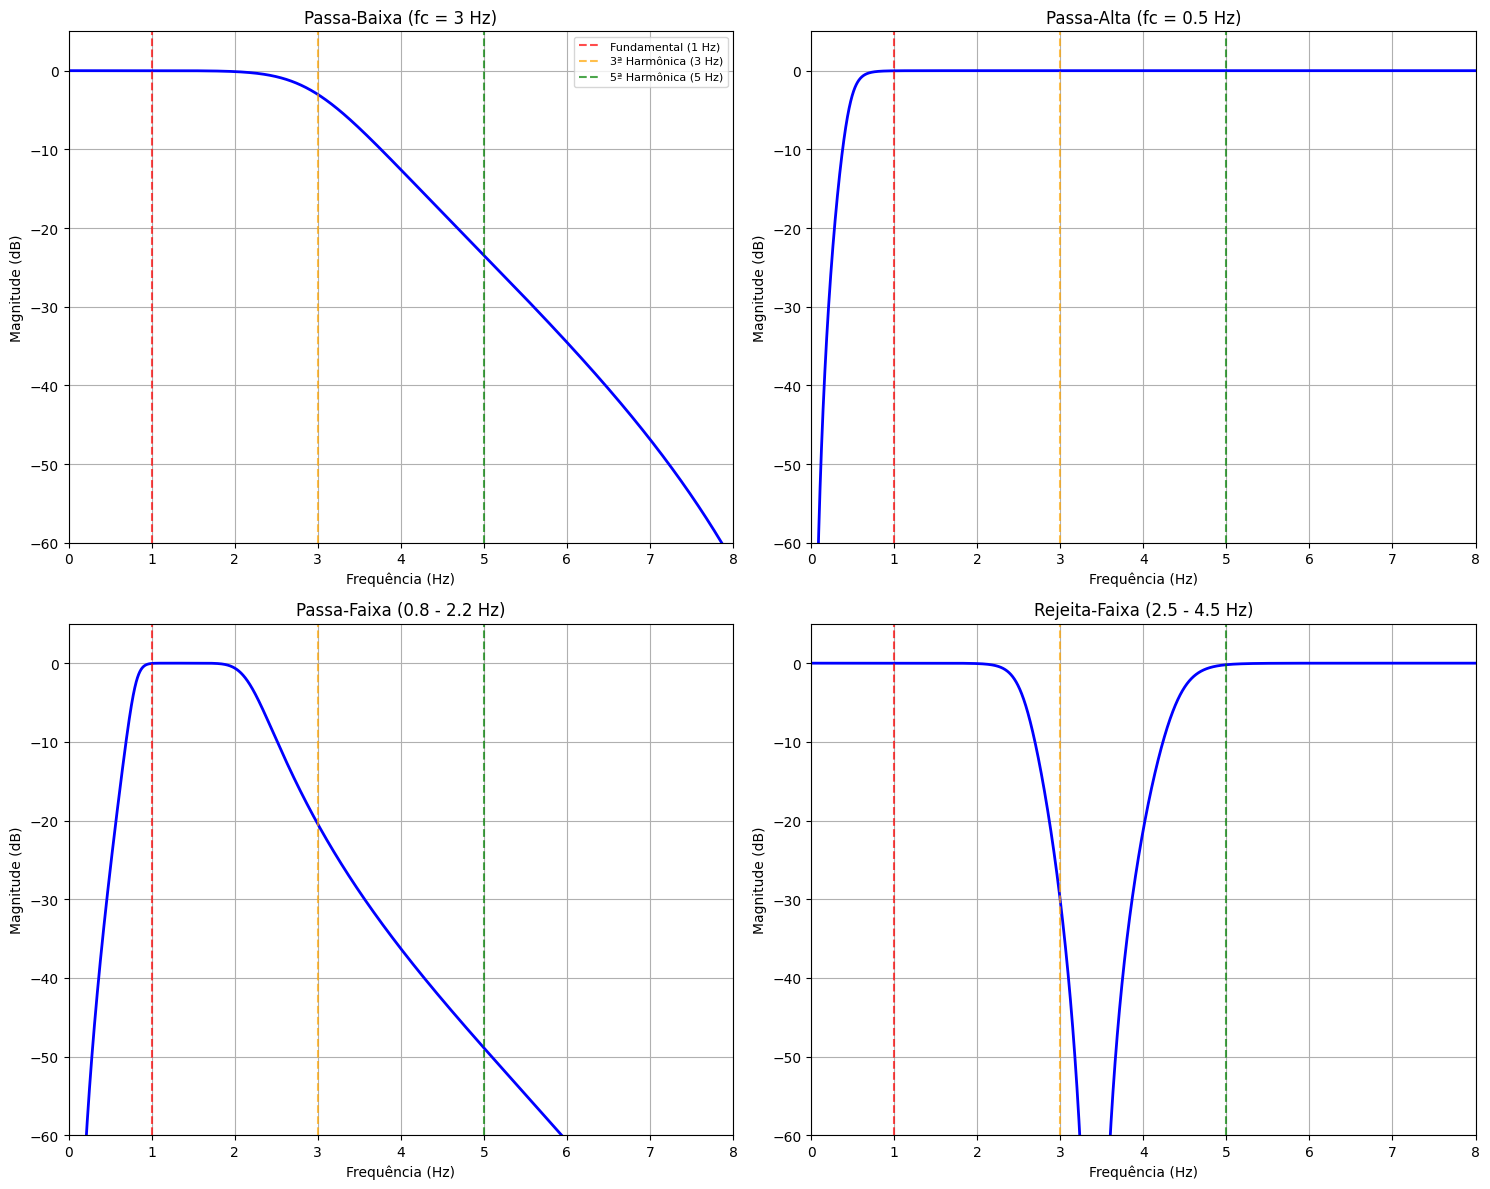

In [6]:
# Plotar as respostas em frequência de todos os filtros
plt.figure(figsize=(15, 12))

filtros = [
    (b_pb, a_pb, f"Passa-Baixa (fc = {freq_corte_pb} Hz)"),
    (b_pa, a_pa, f"Passa-Alta (fc = {freq_corte_pa} Hz)"),
    (b_pf, a_pf, f"Passa-Faixa ({freq_baixa_pf} - {freq_alta_pf} Hz)"),
    (b_rf, a_rf, f"Rejeita-Faixa ({freq_baixa_rf} - {freq_alta_rf} Hz)")
]

for i, (b, a, titulo) in enumerate(filtros):
    plt.subplot(2, 2, i+1)
    w, h = freqz(b, a, worN=8000)
    freq = w * fs_escolhida / (2 * np.pi)
    
    plt.plot(freq, 20 * np.log10(abs(h)), 'b-', linewidth=2)
    plt.title(titulo)
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.xlim(0, 8)  # Mostrar até 8 Hz
    plt.ylim(-60, 5)
    
    # Marcar frequências importantes
    plt.axvline(x=f_fundamental, color='red', linestyle='--', alpha=0.7, label='Fundamental (1 Hz)')
    plt.axvline(x=3*f_fundamental, color='orange', linestyle='--', alpha=0.7, label='3ª Harmônica (3 Hz)')
    plt.axvline(x=5*f_fundamental, color='green', linestyle='--', alpha=0.7, label='5ª Harmônica (5 Hz)')
    
    if i == 0:  # Apenas na primeira subplot
        plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


## Aplicação dos Filtros


In [7]:
# Aplicar todos os filtros ao sinal de entrada
sinal_pb = aplicar_filtro(sinal_processado_entrada, b_pb, a_pb)  # Passa-baixa
sinal_pa = aplicar_filtro(sinal_processado_entrada, b_pa, a_pa)  # Passa-alta
sinal_pf = aplicar_filtro(sinal_processado_entrada, b_pf, a_pf)  # Passa-faixa
sinal_rf = aplicar_filtro(sinal_processado_entrada, b_rf, a_rf)  # Rejeita-faixa

# Calcular espectros dos sinais filtrados
freqs_pb, modulo_pb = calcular_espectro(sinal_pb, fs_escolhida)
freqs_pa, modulo_pa = calcular_espectro(sinal_pa, fs_escolhida)
freqs_pf, modulo_pf = calcular_espectro(sinal_pf, fs_escolhida)
freqs_rf, modulo_rf = calcular_espectro(sinal_rf, fs_escolhida)

print("Filtros aplicados com sucesso!")
print(f"Sinal original: RMS = {np.sqrt(np.mean(sinal_processado_entrada**2)):.4f}")
print(f"Passa-baixa:    RMS = {np.sqrt(np.mean(sinal_pb**2)):.4f}")
print(f"Passa-alta:     RMS = {np.sqrt(np.mean(sinal_pa**2)):.4f}")
print(f"Passa-faixa:    RMS = {np.sqrt(np.mean(sinal_pf**2)):.4f}")
print(f"Rejeita-faixa:  RMS = {np.sqrt(np.mean(sinal_rf**2)):.4f}")


Filtros aplicados com sucesso!
Sinal original: RMS = 0.6754
Passa-baixa:    RMS = 0.6254
Passa-alta:     RMS = 0.6009
Passa-faixa:    RMS = 0.5174
Rejeita-faixa:  RMS = 0.6427


## Comparação: Antes e Depois da Filtragem (Domínio do Tempo)


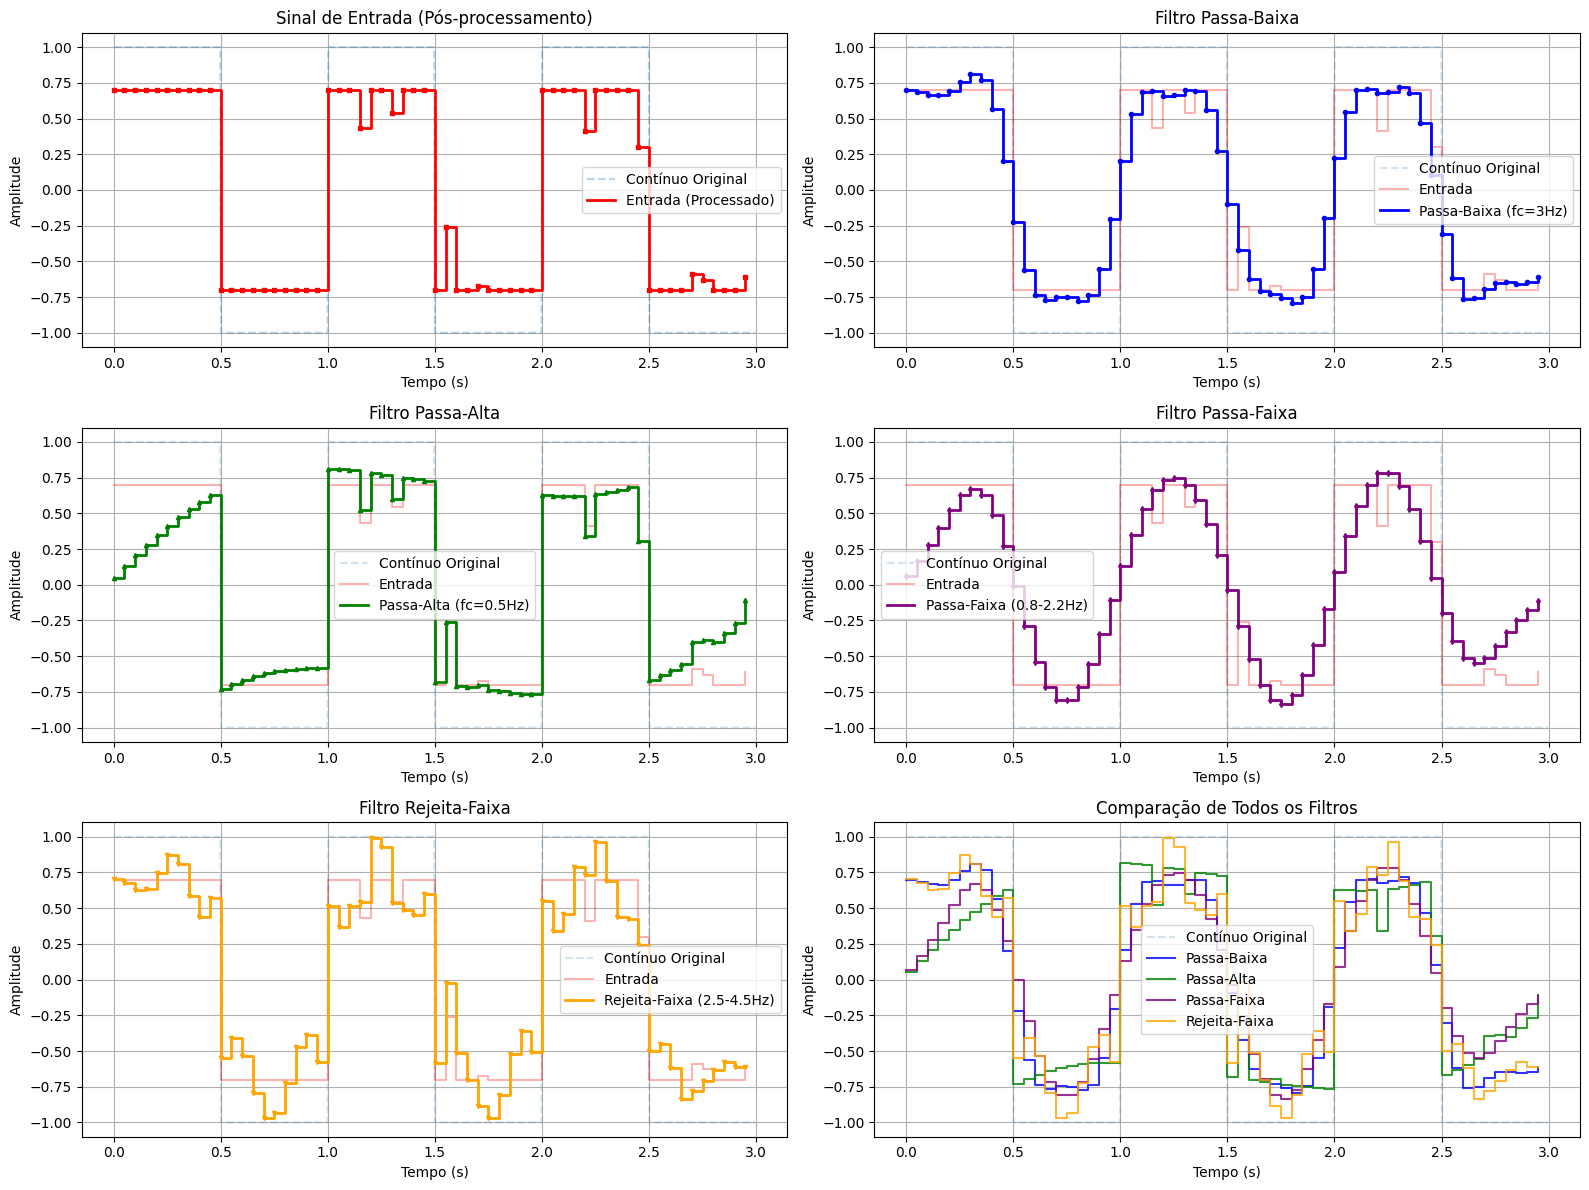

In [8]:
plt.figure(figsize=(16, 12))

# Sinal original (entrada)
plt.subplot(3, 2, 1)
plt.plot(t_continuo, onda_quadrada_continua, label='Contínuo Original', alpha=0.3, linestyle='--')
plt.step(t_amostrado, sinal_processado_entrada, where='post', color='red', label='Entrada (Processado)', linewidth=2)
plt.plot(t_amostrado, sinal_processado_entrada, marker='s', color='red', linestyle='None', markersize=3)
plt.title('Sinal de Entrada (Pós-processamento)')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Filtro Passa-Baixa
plt.subplot(3, 2, 2)
plt.plot(t_continuo, onda_quadrada_continua, label='Contínuo Original', alpha=0.2, linestyle='--')
plt.step(t_amostrado, sinal_processado_entrada, where='post', color='red', alpha=0.3, label='Entrada')
plt.step(t_amostrado, sinal_pb, where='post', color='blue', label=f'Passa-Baixa (fc={freq_corte_pb}Hz)', linewidth=2)
plt.plot(t_amostrado, sinal_pb, marker='o', color='blue', linestyle='None', markersize=3)
plt.title('Filtro Passa-Baixa')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Filtro Passa-Alta
plt.subplot(3, 2, 3)
plt.plot(t_continuo, onda_quadrada_continua, label='Contínuo Original', alpha=0.2, linestyle='--')
plt.step(t_amostrado, sinal_processado_entrada, where='post', color='red', alpha=0.3, label='Entrada')
plt.step(t_amostrado, sinal_pa, where='post', color='green', label=f'Passa-Alta (fc={freq_corte_pa}Hz)', linewidth=2)
plt.plot(t_amostrado, sinal_pa, marker='^', color='green', linestyle='None', markersize=3)
plt.title('Filtro Passa-Alta')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Filtro Passa-Faixa
plt.subplot(3, 2, 4)
plt.plot(t_continuo, onda_quadrada_continua, label='Contínuo Original', alpha=0.2, linestyle='--')
plt.step(t_amostrado, sinal_processado_entrada, where='post', color='red', alpha=0.3, label='Entrada')
plt.step(t_amostrado, sinal_pf, where='post', color='purple', label=f'Passa-Faixa ({freq_baixa_pf}-{freq_alta_pf}Hz)', linewidth=2)
plt.plot(t_amostrado, sinal_pf, marker='d', color='purple', linestyle='None', markersize=3)
plt.title('Filtro Passa-Faixa')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Filtro Rejeita-Faixa
plt.subplot(3, 2, 5)
plt.plot(t_continuo, onda_quadrada_continua, label='Contínuo Original', alpha=0.2, linestyle='--')
plt.step(t_amostrado, sinal_processado_entrada, where='post', color='red', alpha=0.3, label='Entrada')
plt.step(t_amostrado, sinal_rf, where='post', color='orange', label=f'Rejeita-Faixa ({freq_baixa_rf}-{freq_alta_rf}Hz)', linewidth=2)
plt.plot(t_amostrado, sinal_rf, marker='v', color='orange', linestyle='None', markersize=3)
plt.title('Filtro Rejeita-Faixa')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Comparação de todos os filtros
plt.subplot(3, 2, 6)
plt.plot(t_continuo, onda_quadrada_continua, label='Contínuo Original', alpha=0.2, linestyle='--')
plt.step(t_amostrado, sinal_pb, where='post', color='blue', label='Passa-Baixa', alpha=0.8)
plt.step(t_amostrado, sinal_pa, where='post', color='green', label='Passa-Alta', alpha=0.8)
plt.step(t_amostrado, sinal_pf, where='post', color='purple', label='Passa-Faixa', alpha=0.8)
plt.step(t_amostrado, sinal_rf, where='post', color='orange', label='Rejeita-Faixa', alpha=0.8)
plt.title('Comparação de Todos os Filtros')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Comparação Espectral: Antes e Depois da Filtragem


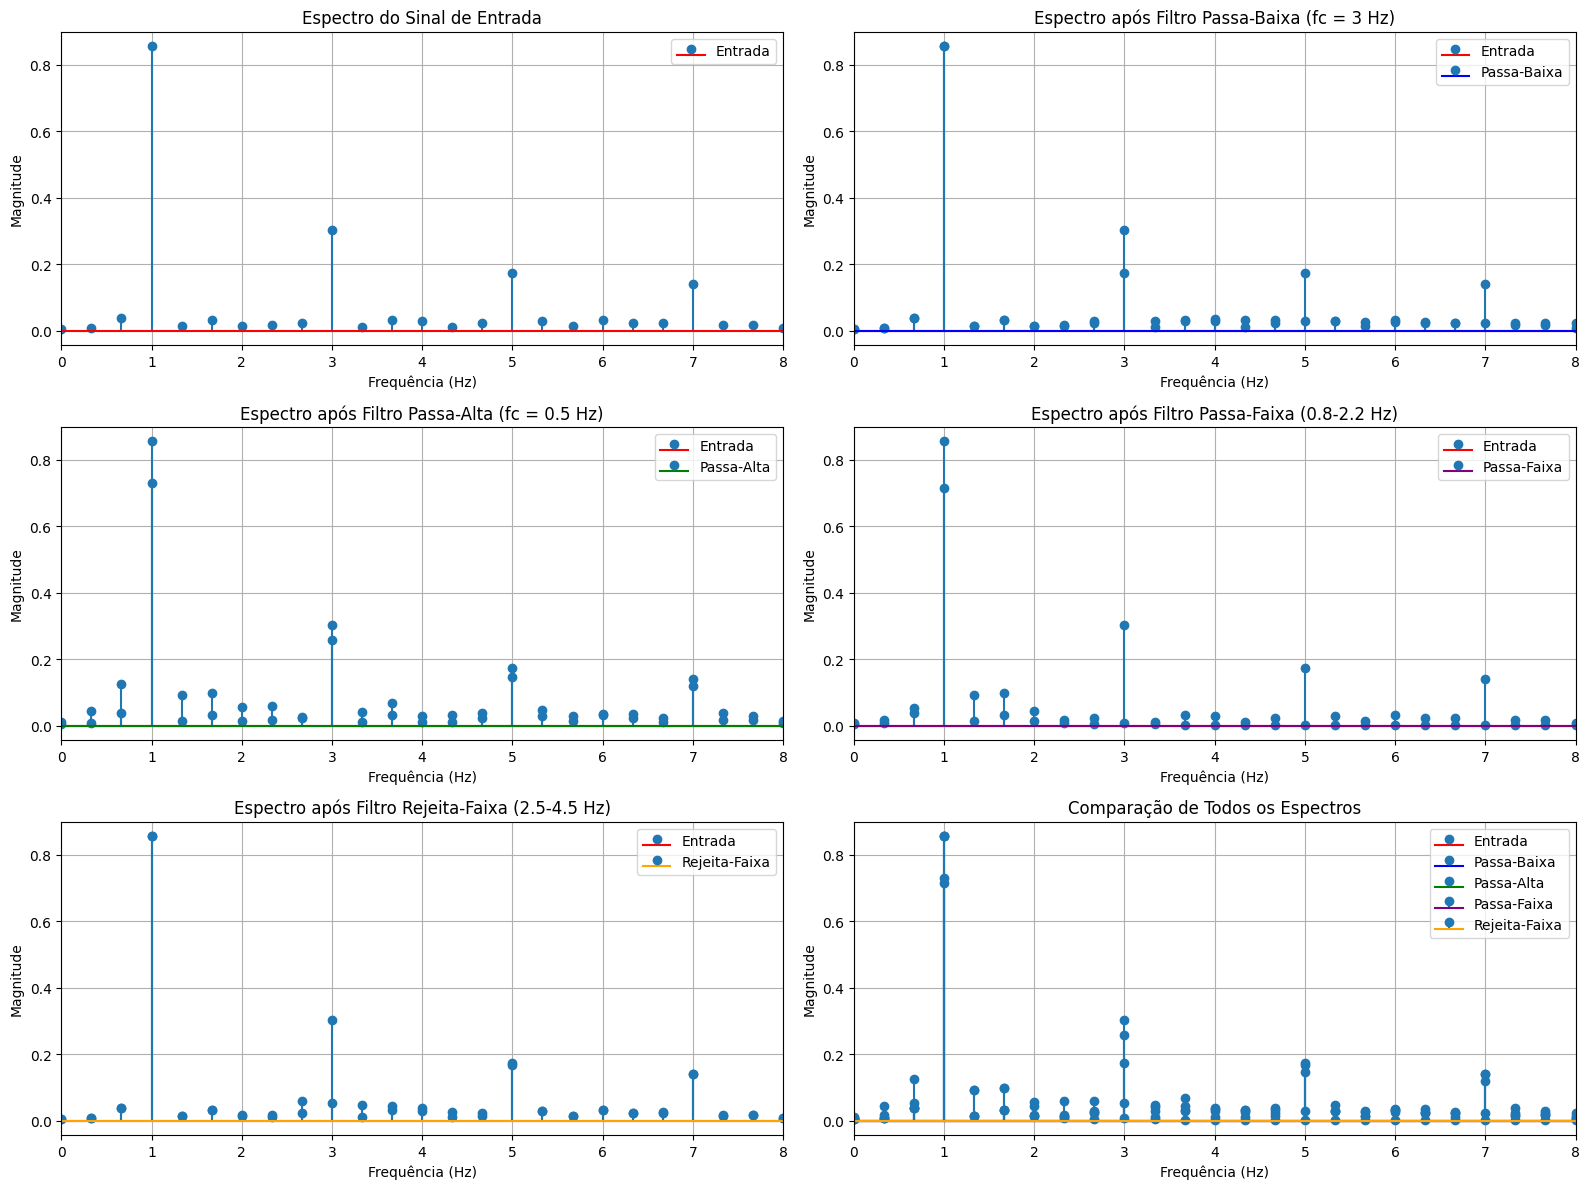

In [13]:
plt.figure(figsize=(16, 12))

# Espectro original
plt.subplot(3, 2, 1)
plt.stem(freqs_entrada, modulo_entrada, basefmt="r-", label='Entrada')
plt.title('Espectro do Sinal de Entrada')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 8)
plt.grid(True)
plt.legend()

# Espectro após filtro passa-baixa
plt.subplot(3, 2, 2)
plt.stem(freqs_entrada, modulo_entrada, basefmt="r-", label='Entrada')
plt.stem(freqs_pb, modulo_pb, basefmt="b-", label='Passa-Baixa')
plt.title(f'Espectro após Filtro Passa-Baixa (fc = {freq_corte_pb} Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 8)
plt.grid(True)
plt.legend()

# Espectro após filtro passa-alta
plt.subplot(3, 2, 3)
plt.stem(freqs_entrada, modulo_entrada, basefmt="r-", label='Entrada')
plt.stem(freqs_pa, modulo_pa, basefmt="g-", label='Passa-Alta')
plt.title(f'Espectro após Filtro Passa-Alta (fc = {freq_corte_pa} Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 8)
plt.grid(True)
plt.legend()

# Espectro após filtro passa-faixa
plt.subplot(3, 2, 4)
plt.stem(freqs_entrada, modulo_entrada, basefmt="r-", label='Entrada')
plt.stem(freqs_pf, modulo_pf, basefmt="purple", label='Passa-Faixa')
plt.title(f'Espectro após Filtro Passa-Faixa ({freq_baixa_pf}-{freq_alta_pf} Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 8)
plt.grid(True)
plt.legend()

# Espectro após filtro rejeita-faixa
plt.subplot(3, 2, 5)
plt.stem(freqs_entrada, modulo_entrada, basefmt="r-", label='Entrada')
plt.stem(freqs_rf, modulo_rf, basefmt="orange", label='Rejeita-Faixa')
plt.title(f'Espectro após Filtro Rejeita-Faixa ({freq_baixa_rf}-{freq_alta_rf} Hz)')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 8)
plt.grid(True)
plt.legend()

# Comparação de todos os espectros
plt.subplot(3, 2, 6)
plt.stem(freqs_entrada, modulo_entrada, basefmt="r-", label='Entrada')
plt.stem(freqs_pb, modulo_pb, basefmt="b-", label='Passa-Baixa')
plt.stem(freqs_pa, modulo_pa, basefmt="g-", label='Passa-Alta')
plt.stem(freqs_pf, modulo_pf, basefmt="purple", label='Passa-Faixa')
plt.stem(freqs_rf, modulo_rf, basefmt="orange", label='Rejeita-Faixa')
plt.title('Comparação de Todos os Espectros')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 8)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Análise dos Efeitos da Filtragem


### 1. Filtro Passa-Baixa (fc = 3 Hz):

**Efeitos Observados:**
* **Redução do Ruído:** Remove efetivamente componentes de alta frequência, incluindo muito do ruído introduzido na Etapa 6.
* **Suavização:** O sinal filtrado apresenta transições mais suaves, perdendo as bordas abruptas características da onda quadrada.
* **Preservação da Fundamental:** A componente fundamental (1 Hz) e a terceira harmônica (3 Hz) são preservadas.
* **Atenuação de Harmônicas Superiores:** Harmônicas de 5 Hz e superiores são significativamente atenuadas.

**Impacto na Fidelidade:**
* Melhora a SNR ao reduzir o ruído.
* Compromete a forma de onda original ao suavizar as transições.
* Adequado para aplicações onde a redução de ruído é prioritária.

### 2. Filtro Passa-Alta (fc = 0.5 Hz):

**Efeitos Observados:**
* **Remoção de DC:** Elimina qualquer componente de corrente contínua.
* **Preservação de Harmônicas:** Mantém a fundamental e todas as harmônicas significativas.
* **Acentuação de Transições:** Enfatiza as mudanças rápidas no sinal.
* **Menor Impacto Visual:** Mudanças sutis na forma de onda comparado aos outros filtros.

**Impacto na Fidelidade:**
* Preserva bem a forma original da onda quadrada.
* Remove bias DC que pode estar presente.
* Útil para eliminar deriva de baixa frequência.

### 3. Filtro Passa-Faixa (0.8 - 2.2 Hz):

**Efeitos Observados:**
* **Seletividade Espectral:** Preserva principalmente a componente fundamental (1 Hz).
* **Forma Senoidal:** O sinal filtrado se aproxima de uma senóide pura.
* **Redução Significativa de Harmônicas:** Atenua tanto harmônicas superiores quanto ruído.
* **Perda de Características da Onda Quadrada:** A forma original é drasticamente alterada.

**Impacto na Fidelidade:**
* Excelente para extrair apenas a componente fundamental.
* Perda significativa da forma de onda original.
* Útil para detecção de frequência ou análise tonal.

### 4. Filtro Rejeita-Faixa (2.5 - 4.5 Hz):

**Efeitos Observados:**
* **Remoção Seletiva:** Remove especificamente a terceira harmônica (3 Hz) e componentes próximas.
* **Preservação Parcial:** Mantém a fundamental e harmônicas superiores (5 Hz, 7 Hz, etc.).
* **Forma Modificada:** A onda quadrada perde parte de sua definição, mas mantém características básicas.
* **Redução de Amplitude:** Diminuição geral na amplitude devido à remoção de componentes importantes.

**Impacto na Fidelidade:**
* Útil para remover interferências em frequências específicas.
* Compromete moderadamente a forma de onda original.
* Aplicável quando há ruído ou interferência em uma faixa específica.


## Escolha do Filtro para Próximas Etapas


**Filtro Escolhido:** Passa-Baixa (fc = 3 Hz)

**Justificativa:**

1. **Redução Efetiva de Ruído:** O filtro passa-baixa remove significativamente o ruído de alta frequência introduzido na Etapa 6, melhorando a qualidade do sinal.

2. **Preservação de Componentes Importantes:** Mantém a frequência fundamental (1 Hz) e a terceira harmônica (3 Hz), que são essenciais para a característica da onda quadrada.

3. **Compromisso Equilibrado:** Oferece um bom equilíbrio entre redução de ruído e preservação da forma de onda, sendo mais prático que o filtro passa-faixa (que remove muitas harmônicas) e mais efetivo na limpeza que o passa-alta.

4. **Aplicabilidade Prática:** Em sistemas de comunicação digital, filtros passa-baixa são comumente usados para limitar a largura de banda e reduzir interferências.

5. **Preparação para Reconstrução:** O sinal filtrado mantém informações suficientes para uma reconstrução analógica razoável, que será o objetivo da Etapa 9.


In [14]:
# Sinal filtrado escolhido para as próximas etapas
sinal_filtrado_final = sinal_pb

print("Sinal filtrado pronto para as próximas etapas:")
print(f"- Filtro aplicado: Passa-Baixa (fc = {freq_corte_pb} Hz)")
print(f"- Número de amostras: {len(sinal_filtrado_final)}")
print(f"- Taxa de amostragem: {fs_escolhida} Hz")
print(f"- Faixa de amplitude: [{np.min(sinal_filtrado_final):.3f}, {np.max(sinal_filtrado_final):.3f}]")
print(f"- RMS: {np.sqrt(np.mean(sinal_filtrado_final**2)):.4f}")

# Comparação de qualidade
mse_original = np.mean((sinal_processado_entrada - sinal_digital_original)**2)
mse_filtrado = np.mean((sinal_filtrado_final - sinal_digital_original)**2)

print(f"\nComparação de qualidade (MSE em relação ao sinal digital original):")
print(f"- Sinal processado (entrada): {mse_original:.6f}")
print(f"- Sinal filtrado: {mse_filtrado:.6f}")
print(f"- Melhoria: {((mse_original - mse_filtrado)/mse_original)*100:.1f}%")

# Este sinal (sinal_filtrado_final) será usado nas Etapas 8 e 9


Sinal filtrado pronto para as próximas etapas:
- Filtro aplicado: Passa-Baixa (fc = 3 Hz)
- Número de amostras: 60
- Taxa de amostragem: 20 Hz
- Faixa de amplitude: [-0.791, 0.809]
- RMS: 0.6254

Comparação de qualidade (MSE em relação ao sinal digital original):
- Sinal processado (entrada): 0.117809
- Sinal filtrado: 0.201376
- Melhoria: -70.9%
